<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
from bioMONAI.data import *
from bioMONAI.transforms import *
from bioMONAI.core import *
from bioMONAI.core import Path
from bioMONAI.data import *
from bioMONAI.nets import BasicUNet, DynUNet
from bioMONAI.losses import *
from bioMONAI.losses import SSIMLoss
from bioMONAI.metrics import *
from bioMONAI.datasets import download_file, split_dataframe, add_columns_to_csv

import os

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = get_device()
print(device)

cuda


---

## Download dataset

In the next cell, we will download a subset of the RXRX1 dataset from the MONAI repository. This dataset contains multispectral images that we will use for our classification task. The [`download_file`](https://deepCLEM.github.io/bioMONAI/datasets.html#download_file) function is used to download and extract the dataset to a specified directory. 

- The dataset URL is specified, and a hash is provided to ensure data integrity.
- The `extract` parameter is set to `True` to automatically extract the downloaded zip file.
- The `extract_dir` parameter is left empty, meaning the contents will be extracted to the specified directory.


>- You can change the `url` variable to point to a different dataset if needed.
>- Modify the `extract_dir` parameter to specify a different extraction directory.
>- Ensure that the `hash` value matches the dataset you are downloading to avoid data corruption issues.

In [ ]:
# Define the base URL for the dataset
url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/rxrx1_subset_monai.zip"

download_file(url, "../_data", extract=True, hash='e80db433db641bb390ade991b81f98814a26c7de30e0da6f20e8abddf7a84538', extract_dir='')

Unzipping contents of '/home/biagio/Code/bioMONAI/nbs/_data/420070ba36287636b45f69ca979afd7a-rxrx1_subset_monai.zip' to '/home/biagio/Code/bioMONAI/nbs/_data/'


The file has been downloaded and saved to: ../_data
Extracted files have been saved to: ../_data


## Prepare Image Paths and Update Metadata

In the next cell, we will prepare the image paths for each channel and update the metadata CSV file with these paths. This step is crucial for organizing the dataset and ensuring that each image is correctly associated with its corresponding metadata.

- We will read the metadata CSV file and extract the site IDs.
- For each site ID, we will generate the paths for the six channels of images.
- These paths will be stored in a dictionary and added as new columns to the metadata CSV file.
- A new CSV file will be created to avoid overwriting the original metadata file.


>- You can modify the `data_folder` and `csv_file` variables to point to a different dataset or metadata file.
>- If your dataset contains a different number of channels, adjust the range in the `channel_list` generation accordingly.
>- Ensure that the directory structure and file naming conventions match those expected by the code.

In [ ]:
data_folder = '../_data/rxrx1_subset_monai/'
csv_file = data_folder + 'metadata.csv'

import pandas as pd
df = pd.read_csv(csv_file)

ch1, ch2, ch3, ch4, ch5,ch6 = [],[],[],[],[],[]
for sid in df['site_id']: 
    site_id = sid.split('_')
    base_image_path = os.path.join('images', site_id[0], f'Plate{site_id[1]}', f'{site_id[2]}_s{site_id[3]}_w')
    channel_list = [f'{base_image_path}{i}.png' for i in range(1,7)]
    ch1.append(channel_list[0])
    ch2.append(channel_list[1])
    ch3.append(channel_list[2])
    ch4.append(channel_list[3])
    ch5.append(channel_list[4])
    ch6.append(channel_list[5])
image_paths = {'channel 1': ch1, 'channel 2': ch2, 'channel 3': ch3, 'channel 4': ch4, 'channel 5': ch5, 'channel 6': ch6}
# Let's create a new csv file to avoid overwriting the original one
new_csv_file = data_folder + 'metadata_updated.csv'
add_columns_to_csv(csv_file, image_paths, new_csv_file)

Columns ['channel 1', 'channel 2', 'channel 3', 'channel 4', 'channel 5', 'channel 6'] added successfully. Updated file saved to '../_data/rxrx1_subset_monai/metadata_updated.csv'


## Split Dataset into Train, Validation, and Test Sets

In the next cell, we will split the updated metadata CSV file into training, validation, and test sets. This step is essential for training and evaluating our classification model. The [`split_dataframe`](https://deepCLEM.github.io/bioMONAI/datasets.html#split_dataframe) function is used to perform the split based on the specified fractions.

- The `train_fraction` parameter determines the proportion of the dataset to be used for training.
- The `valid_fraction` parameter determines the proportion of the dataset to be used for validation.
- The `split_column` parameter specifies the column to be used for splitting the dataset.
- The `add_is_valid` parameter adds a column to indicate whether a sample belongs to the validation set.
- The `train_path`, `test_path`, and `valid_path` parameters specify the file paths for the resulting CSV files.
- The `data_save_path` parameter specifies the directory where the CSV files will be saved.

> - You can adjust the `train_fraction` and `valid_fraction` parameters to change the proportions of the splits.
> - Modify the `split_column` parameter if you want to use a different column for splitting.
> - Ensure that the `data_save_path` directory exists and has write permissions.

In [ ]:
split_dataframe(new_csv_file, 
                train_fraction=0.7, 
                valid_fraction=0.05, 
                split_column='dataset', 
                add_is_valid=True, 
                train_path="train.csv", 
                test_path="test.csv", 
                valid_path="valid.csv", 
                data_save_path=data_folder
                )

Train and test files saved as '../_data/rxrx1_subset_monai/train.csv' and '../_data/rxrx1_subset_monai/test.csv' respectively.
'is_valid' column added to '../_data/rxrx1_subset_monai/train.csv' for validation samples.


## Data Augmentation and DataLoader Preparation

In the next cell, we will define the data augmentation techniques and prepare the data loaders for training and validation. Data augmentation is crucial for improving the generalization of our model by artificially increasing the diversity of the training dataset. We will use a combination of intensity scaling, random cropping, rotation, and flipping transformations.

- The [`ScaleIntensityPercentiles`](https://deepCLEM.github.io/bioMONAI/transforms.html#scaleintensitypercentiles) transformation scales the intensity values of the images based on the specified percentiles.
- The `RandomResizedCrop` transformation randomly crops the images to the specified size with a random scale.
- The [`RandRot90`](https://deepCLEM.github.io/bioMONAI/transforms.html#randrot90) transformation randomly rotates the images by 90 degrees with the specified probability.
- The [`RandFlip`](https://deepCLEM.github.io/bioMONAI/transforms.html#randflip) transformation randomly flips the images horizontally or vertically with the specified probability.
- The [`BioDataLoaders.class_from_csv`](https://deepCLEM.github.io/bioMONAI/data.html#biodataloaders.class_from_csv) function is used to create the data loaders from the CSV file containing the image paths and labels.

> - You can adjust the `bs` variable to change the batch size.
> - Modify the parameters of the transformations to experiment with different augmentation techniques.
> - Ensure that the `fn_col` and `label_col` parameters match the columns in your CSV file.
> - Set `show_summary` to `True` to display a summary of the data loaders.

In [ ]:
from fastai.vision.all import RandomResizedCrop

bs = 8

itemTfms = [ScaleIntensityPercentiles(1,99), RandomResizedCrop(512,min_scale=0.9, max_scale=1.1), RandRot90(prob=.75), RandFlip(prob=0.5)]
batchTfms = []

data = BioDataLoaders.class_from_csv(
    data_folder,
    'train.csv',
    fn_col=[12,13,14,15,16,17],
    label_col=3,
    valid_col=-1,
    seed=42, 
    img_cls=BioImageMulti,
    item_tfms=itemTfms,
    batch_tfms=batchTfms, 
    show_summary=False,
    bs = bs,
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 929 
validation images: 71


## Visualize Data Batch

In the next cell, we will visualize a batch of images from the training dataset. This step is essential for verifying that the data augmentation techniques are applied correctly and that the images are loaded as expected. The [`show_batch`](https://deepCLEM.github.io/bioMONAI/data.html#show_batch) method of the [`BioDataLoaders`](https://deepCLEM.github.io/bioMONAI/data.html#biodataloaders) class is used to display a batch of images with their corresponding labels.

- The `max_slices` parameter specifies the maximum number of slices to display for each image.
- The `layout` parameter determines the layout of the displayed images. The 'multirow' layout arranges the images in multiple rows.

> - You can adjust the `max_slices` parameter to display more or fewer slices per image.
> - Modify the `layout` parameter to experiment with different layouts, such as 'single' or 'grid'.
> - Ensure that the data loaders are correctly defined and contain the expected images and labels.

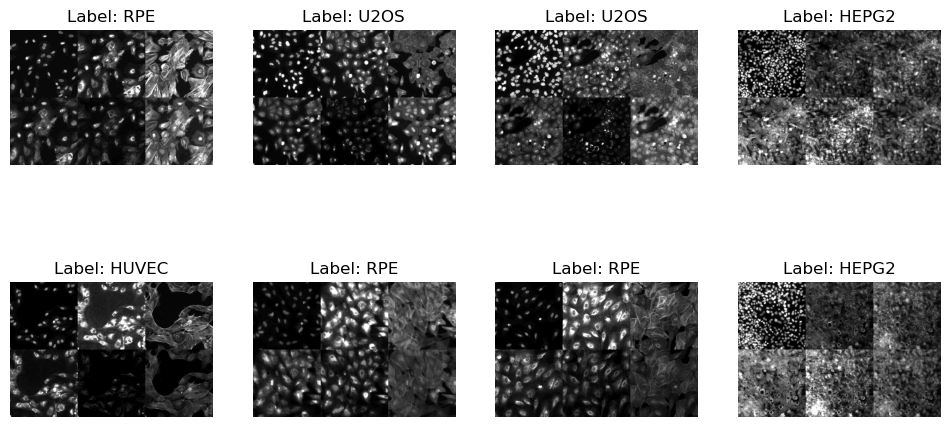

In [ ]:
data.show_batch(max_slices=6, layout='multirow')

## Visualize a Specific Image

In the next cell, we will visualize a specific image from the dataset using its index. This step is useful for inspecting individual images and verifying their quality and labels. The `do_item` method of the [`BioDataLoaders`](https://deepCLEM.github.io/bioMONAI/data.html#biodataloaders) class is used to retrieve the image and its label, and the `show` method is used to display the image.

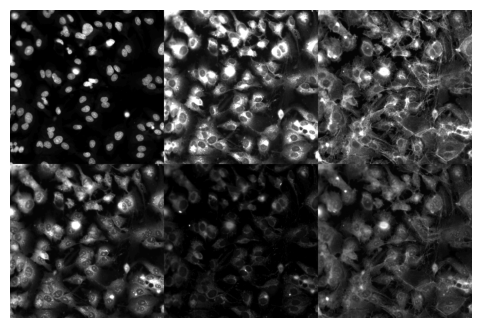

In [ ]:
a = data.do_item(100)
a[0].show(max_slices=6, layout='multirow');

---

## Define and Train the Model

In the next cell, we will define and train a DenseNet169 model for our multispectral classification task. The model is initialized with the following parameters:
- `spatial_dims=2`: Specifies that the input images are 2D.
- `in_channels=6`: Specifies the number of input channels, which corresponds to the six multispectral channels.
- `out_channels=data.c`: Specifies the number of output channels, which corresponds to the number of classes in our dataset.
- `pretrained=True`: Initializes the model with pretrained weights.

We will also define the metrics to evaluate the model's performance during training. The `RocAuc` and `accuracy` metrics are used to measure the model's performance.

The [`fastTrainer`](https://deepCLEM.github.io/bioMONAI/core.html#fasttrainer) class is used to train the model with the specified data loaders and metrics. The `fine_tune` method is called to fine-tune the model for a specified number of epochs, with an initial phase of freezing the pretrained layers.

> - You can experiment with different model architectures by replacing `DenseNet169` with other models from the `monai.networks.nets` module.
> - Adjust the `in_channels` parameter if your dataset contains a different number of channels.
> - Modify the `out_channels` parameter if your dataset has a different number of classes.
> - Experiment with different metrics by adding or removing metrics from the `metrics` list.
> - Adjust the number of epochs and the `freeze_epochs` parameter to control the training process.

In [ ]:
from monai.networks.nets import DenseNet169

model = DenseNet169(spatial_dims=2, in_channels=6, out_channels=data.c, pretrained=True)

In [ ]:
from fastai.vision.all import RocAuc, accuracy
metrics = [RocAuc(), accuracy]

trainer = fastTrainer(data, model, metrics=metrics, show_summary=False)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.559674,9.052959,0.772129,0.492958,00:21
1,0.633247,0.418777,0.968444,0.845070,00:14


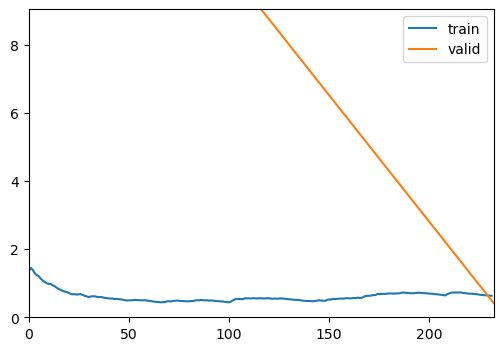

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.399818,0.763117,0.975527,0.887324,00:14
1,0.404023,0.498850,0.985939,0.901408,00:14
2,0.247609,0.053720,1.000000,0.985915,00:14
3,0.182609,0.046695,1.000000,0.985915,00:14


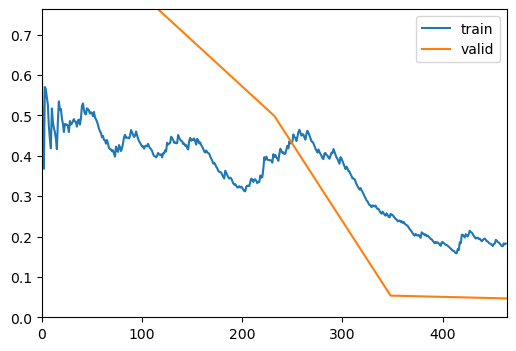

In [ ]:
trainer.fine_tune(4, freeze_epochs=2)

## Save the Trained Model

In the next cell, we will save the trained model to a file. This step is crucial for preserving the model's state after training, allowing us to load and use the model later without retraining. The `save` method of the [`fastTrainer`](https://deepCLEM.github.io/bioMONAI/core.html#fasttrainer) class is used to save the model to the specified file path.

- The `save` method takes the file name as an argument and saves the model's state dictionary to a file with the `.pth` extension.
- The saved model can be loaded later using the `load` method of the [`fastTrainer`](https://deepCLEM.github.io/bioMONAI/core.html#fasttrainer) class.

> - You can change the file name to save the model with a different name.
> - Ensure that the directory where the model is saved exists and has write permissions.
> - Consider saving multiple versions of the model during training to keep track of different checkpoints.

In [ ]:
trainer.save('multispectral-classification-model')

Path('../_data/rxrx1_subset_monai/models/multispectral-classification-model.pth')

---

## Evaluate the Model on Test Data

In the next cell, we will evaluate the trained model on the test dataset. This step is crucial for assessing the model's performance on unseen data and understanding its generalization capabilities. The [`BioDataLoaders.class_from_csv`](https://deepCLEM.github.io/bioMONAI/data.html#biodataloaders.class_from_csv) function is used to create the data loader for the test dataset, and the [`evaluate_classification_model`](https://deepCLEM.github.io/bioMONAI/core.html#evaluate_classification_model) function is used to compute the evaluation metrics.

- The `fn_col` parameter specifies the columns containing the file paths for the multispectral channels.
- The `label_col` parameter specifies the column containing the labels.
- The `valid_pct` parameter is set to 0, indicating that no validation split is needed for the test dataset.
- The `item_tfms` parameter applies the [`ScaleIntensityPercentiles`](https://deepCLEM.github.io/bioMONAI/transforms.html#scaleintensitypercentiles) transformation to the test images.
- The `batch_tfms` parameter applies any batch-level transformations (if defined).
- The `bs` parameter specifies the batch size for loading the test data.
- The [`evaluate_classification_model`](https://deepCLEM.github.io/bioMONAI/core.html#evaluate_classification_model) function takes the trained model, test data loader, and evaluation metrics as inputs and returns the computed scores.

> - You can adjust the `bs` variable to change the batch size for loading the test data.
> - Modify the `fn_col` and `label_col` parameters to match the columns in your test CSV file.
> - Add or remove transformations in the `item_tfms` and `batch_tfms` lists to experiment with different preprocessing techniques.
> - Set `show_graph` to `True` to visualize the evaluation results.

In [ ]:
test_data = BioDataLoaders.class_from_csv(
    data_folder,
    'test.csv',
    fn_col=[12,13,14,15,16,17],
    label_col=3,
    valid_pct=0,
    seed=42, 
    img_cls=BioImageMulti,
    item_tfms=[ScaleIntensityPercentiles(1,99)],
    batch_tfms=batchTfms, 
    show_summary=False,
    bs = 50,
    )

              precision    recall  f1-score   support

       HEPG2       0.56      0.78      0.65        50
       HUVEC       0.94      0.90      0.92        50
         RPE       0.67      0.94      0.78        50
        U2OS       1.00      0.24      0.39        50

    accuracy                           0.71       200
   macro avg       0.79      0.72      0.68       200
weighted avg       0.79      0.71      0.68       200


Most Confused Classes:


[('U2OS', 'HEPG2', 31), ('HEPG2', 'RPE', 11), ('U2OS', 'RPE', 7), ('HUVEC', 'RPE', 5), ('RPE', 'HUVEC', 3)]


,Value
CrossEntropyLossFlat,
Mean,1.013312
Median,0.796461
Standard Deviation,0.357889
Min,0.743670
Max,1.743668
Q1,0.747447
Q3,1.290924


,Value
accuracy,
Mean,0.715000
Median,1.000000
Standard Deviation,0.451414
Min,0.000000
Max,1.000000
Q1,0.000000
Q3,1.000000


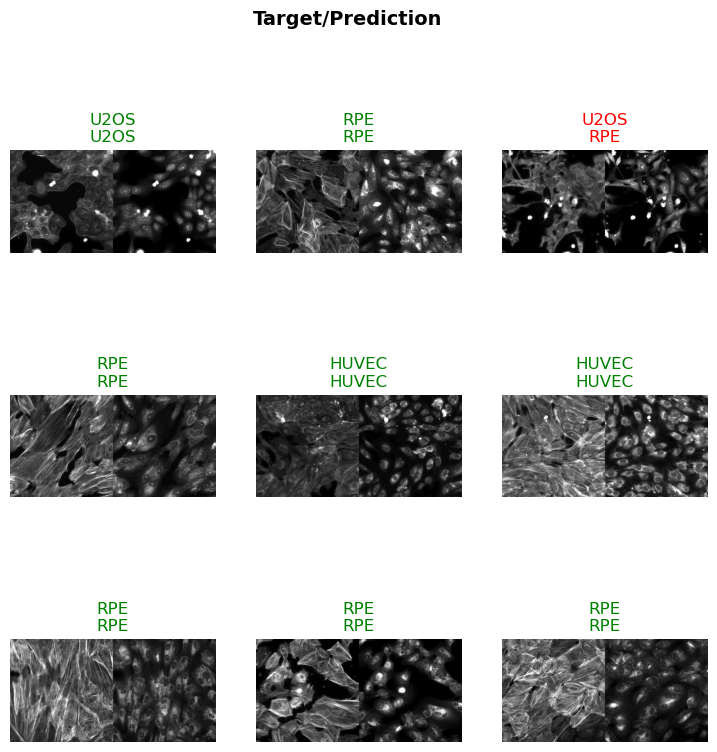

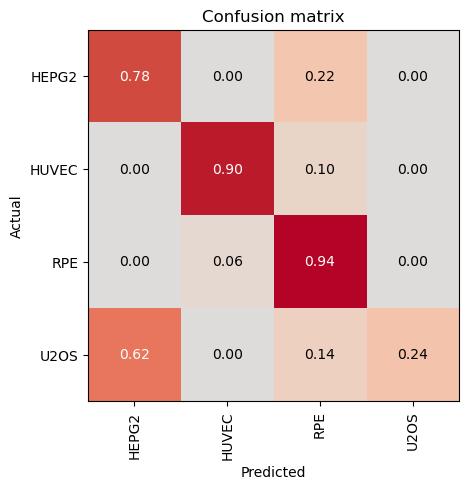

In [ ]:
scores = evaluate_classification_model(trainer, test_data, metrics=accuracy, show_graph=False)